# Composite in Subtropical Area

In [38]:
## import libraries
from xmitgcm import open_mdsdataset
from datetime import datetime
import numpy as np
import xarray as xr
import scipy.interpolate
import math
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

In [2]:
area = 'sub'  ## sub/frt
zs = 0
ze = 19
slon_sub = 5   # start longitude is 5°E
elon_sub = 58  # end longitude is 58°E
slat_sub = 5   # start latitude is 5°N
elat_sub = 25  # end latitude is 25°N
xs_sub = 32*slon_sub-1
xe_sub = 32*elon_sub
ys_sub = 32*slat_sub-1
ye_sub = 32*elat_sub

In [3]:
xs_sub, xe_sub, ys_sub, ye_sub

(159, 1856, 159, 800)

## 1. data preprocessing (only in first run)

### 1.1 climatology

In [ ]:
%%time
###### 600×600 t-uvw-eta气候态数据 ######
ds_ca_THETA = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'theta_ave'}).chunk() # THETA[1460,29,600,600]
ds_ca_MOM   = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'xyMom_ave'}).chunk() # UVEL, VVEL, WVEL, UVELSQ, VVELSQ[1460,29,600,600]
ds_ca_ETAN  = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'etan_ave'}).chunk()  # ETAN, oceQsw[1460,600,600]

# 求时间平均
ca600_u = np.mean(ds_ca_MOM.UVEL[:,:,:,:],0)    # ca600_u: Clim_Averge u in grid 600x600
ca600_v = np.mean(ds_ca_MOM.VVEL[:,:,:,:],0)    # ca600_v: Clim_Averge v in grid 600x600
ca600_w = np.mean(ds_ca_MOM.WVEL[:,:,:,:],0)    # ca600_w: Clim_Averge w in grid 600x600
ca600_t = np.mean(ds_ca_THETA.THETA[:,:,:,:],0) # ca600_t: Clim_Averge theta in grid 600x600
ca600_e = np.mean(ds_ca_ETAN.ETAN[:,:,:],0)     # ca600_e: Clim_Averge etan in grid 600x600

# 从 600×600 插值到 1920×1920 #####
ds_1y= open_mdsdataset('/data2/home/liutongya/data/box32_out/', prefix={'theta_ave', 'xyMom_ave', 'etan_ave'}).chunk()
ca_u = ca600_u.interp(YC=ds_1y.YC, XG=ds_1y.XG)  # ca_u: Clim_Averge u
ca_v = ca600_v.interp(YG=ds_1y.YG, XC=ds_1y.XC)  # ca_v: Clim_Averge v
ca_w = ca600_w.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_w: Clim_Averge w
ca_t = ca600_t.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_t: Clim_Averge theta
ca_e = ca600_e.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_e: Clim_Averge etan

In [ ]:
# 从1920×1920气候态数据中切片出副热带：
sub_cau = ca_u.sel(XG=slice(ds_1y.XG[xs_sub],ds_1y.XG[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)
sub_cav = ca_v.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YG=slice(ds_1y.YG[ys_sub],ds_1y.YG[ye_sub]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)
sub_caw = ca_w.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,
                   Zl=slice(ds_1y.Zl[zs],ds_1y.Zl[ze-1]) ,)
sub_cat = ca_t.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)
sub_cae = ca_e.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,)

In [ ]:
%%time
sub_cau.to_netcdf('/data3/home/zhangrd/data/clim_variables/sub_climU.nc')
sub_cav.to_netcdf('/data3/home/zhangrd/data/clim_variables/sub_climV.nc')
sub_caw.to_netcdf('/data3/home/zhangrd/data/clim_variables/sub_climW.nc')
sub_cat.to_netcdf('/data3/home/zhangrd/data/clim_variables/sub_climT.nc')
sub_cae.to_netcdf('/data3/home/zhangrd/data/clim_variables/sub_climEtan.nc')

### 1.2  anomaly

In [ ]:
# ds_1y = open_mdsdataset('/data2/home/liutongya/data/box32_out/', prefix={'theta_ave', 'xyMom_ave', 'etan_ave'}).chunk()
sub_1y= xr.open_dataset('/data/home/zhangrd/sub_1y.nc')
sub_1y

In [ ]:
# 从1920×1920切片出副热带(from 1y data)：
# sub_w = ds_1y.WVEL.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,
#                         Zl=slice(ds_1y.Zl[zs],ds_1y.Zl[ze-1]) ,)
# sub_t = ds_1y.THETA.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,
#                          Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)
# sub_e = ds_1y.ETAN.sel(XC=slice(ds_1y.XC[xs_sub],ds_1y.XC[xe_sub]) , YC=slice(ds_1y.YC[ys_sub],ds_1y.YC[ye_sub]) ,)
sub_u = sub_1y.UVEL[:,:,:,:-1]#因为sub_1y的XG/YG长度为1699/643，比原本XC/YC（长度为1698/642）长
sub_v = sub_1y.VVEL[:,:,:-1,:]#因为sub_1y的XG/YG长度为1699/643，比原本XC/YC（长度为1698/642）长
sub_w = sub_1y.WVEL
sub_t = sub_1y.THETA
sub_e = sub_1y.ETAN

In [ ]:
%%time
sub_u.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_UVEL.nc')
sub_v.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_VVEL.nc')
sub_w.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_WVEL.nc')
sub_t.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_THETA.nc')
sub_e.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_ETAN.nc')

In [ ]:
%%time
sub_cu = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/sub_climU.nc')
sub_cv = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/sub_climV.nc')
sub_cw = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/sub_climW.nc')
sub_ct = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/sub_climT.nc')
sub_ce = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/sub_climEtan.nc')

sub_u = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/sub_UVEL.nc')
sub_v = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/sub_VVEL.nc')
sub_w = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/sub_WVEL.nc')
sub_t = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/sub_THETA.nc')
sub_e = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/sub_ETAN.nc')

In [ ]:
%%time
sub_ua = sub_u-sub_cu
sub_va = sub_v-sub_cv
sub_wa = sub_w-sub_cw
sub_ta = sub_t-sub_ct
sub_ea = sub_e-sub_ce

In [ ]:
%%time
sub_ua.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_ua.nc')
sub_va.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_va.nc')
sub_wa.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_wa.nc')
sub_ta.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_ta.nc')
sub_ea.to_netcdf('/data3/home/zhangrd/data/1y_variables/sub_ea.nc')

## 2. read data

In [4]:
var = '1y'
file_paths = {
    '1y': {
        'u': '/data3/home/zhangrd/data/1y_variables/sub_UVEL.nc',
        'v': '/data3/home/zhangrd/data/1y_variables/sub_VVEL.nc',
        'w': '/data3/home/zhangrd/data/1y_variables/sub_WVEL.nc',
        't': '/data3/home/zhangrd/data/1y_variables/sub_THETA.nc',
        'e': '/data3/home/zhangrd/data/1y_variables/sub_ETAN.nc'},
    'clim': {
        'u': '/data3/home/zhangrd/data/clim_variables/sub_climU.nc',
        'v': '/data3/home/zhangrd/data/clim_variables/sub_climV.nc',
        'w': '/data3/home/zhangrd/data/clim_variables/sub_climW.nc',
        't': '/data3/home/zhangrd/data/clim_variables/sub_climT.nc',
        'e': '/data3/home/zhangrd/data/clim_variables/sub_climEtan.nc'},
    'anom': {
        'u': '/data3/home/zhangrd/data/1y_variables/sub_ua.nc',
        'v': '/data3/home/zhangrd/data/1y_variables/sub_va.nc',
        'w': '/data3/home/zhangrd/data/1y_variables/sub_wa.nc',
        't': '/data3/home/zhangrd/data/1y_variables/sub_ta.nc',
        'e': '/data3/home/zhangrd/data/1y_variables/sub_ea.nc'}
}
if var not in file_paths:
    raise ValueError(f'invalid var: {var}')

paths = file_paths[var]
sub_u = xr.open_dataset(paths['u']).UVEL
sub_v = xr.open_dataset(paths['v']).VVEL
sub_w = xr.open_dataset(paths['w']).WVEL
sub_t = xr.open_dataset(paths['t']).THETA
sub_e = xr.open_dataset(paths['e']).ETAN

a_sub = xr.open_dataset('/data/home/zhangrd/eddyTracker/tracks_MITgcm/1y_sub/Anticyclonic.nc')
c_sub = xr.open_dataset('/data/home/zhangrd/eddyTracker/tracks_MITgcm/1y_sub/Cyclonic.nc')

In [5]:
cc = np.load('/data/home/zhangrd/Data/coreNum/cc_sub_radius.npy')
ac = np.load('/data/home/zhangrd/Data/coreNum/ca_sub_radius.npy')

c0 = np.where(cc==0)
c2 = np.where(cc==2)
c4 = np.where(cc==4)
a0 = np.where(ac==0)
a2 = np.where(ac==2)
a4 = np.where(ac==4)

## 3. composite of dipole eddies

In [6]:
sum_c2u = np.zeros((ze,101,101))
sum_c2v = np.zeros((ze,101,101))
sum_c2w = np.zeros((ze,101,101))
sum_c2t = np.zeros((ze,101,101))
sum_c2e = np.zeros((101,101))
sum_a2u = np.zeros((ze,101,101))
sum_a2v = np.zeros((ze,101,101))
sum_a2w = np.zeros((ze,101,101))
sum_a2t = np.zeros((ze,101,101))
sum_a2e = np.zeros((101,101))

x1 = np.linspace( -2, 2., 101 )
y1 = np.linspace( -2, 2., 101 )

In [7]:
%%time
######## 1Y & ANOM CE ########
num_in  = 0
num_out = 0
for i in c2[0]:
    lenth =  c_sub.effective_radius[i]*2/(1000*111)
    iis   =  math.floor((c_sub.longitude[i]-lenth)*32)-xs_sub
    iie   =  math.ceil((c_sub.longitude[i]+lenth)*32)-xs_sub
    jjs   =  math.floor((c_sub.latitude[i]-lenth)*32)-ys_sub
    jje   =  math.ceil((c_sub.latitude[i]+lenth)*32)-ys_sub
    if( iis<0 or jjs<0 or iie>=1698 or jje>=642 ):
        num_out = num_out+1
    else:
        num_in = num_in+1
        lons   =  sub_w.XC.data[iis+1]
        lone   =  sub_w.XC.data[iie-1]
        lats   =  sub_w.YC.data[jjs+1]
        late   =  sub_w.YC.data[jje-1]
        
        days = int( (c_sub.time[i]-np.datetime64('2022-01-01T00:00:00.000000000'))/np.timedelta64(1,'D') )

        xnew = np.linspace( lons, lone, 101 )
        ynew = np.linspace( lats, late, 101 )
        
        u100 = sub_u[days, :, jjs:jje, iis:iie].interp(YC=ynew, XG=xnew)
        v100 = sub_v[days, :, jjs:jje, iis:iie].interp(YG=ynew, XC=xnew)
        w100 = sub_w[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        t100 = sub_t[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        e100 = sub_e[days, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        
        ds_c2u = u100.assign_coords(XG=x1, YC=y1)
        ds_c2v = v100.assign_coords(XC=x1, YG=y1)
        ds_c2w = w100.assign_coords(XC=x1, YC=y1)
        ds_c2t = t100.assign_coords(XC=x1, YC=y1)
        ds_c2e = e100.assign_coords(XC=x1, YC=y1) #xr.DataArray(e100, coords={'YC':y1,'XC':x1}, dims=['YC','XC'])
        
        sum_c2u = np.add(sum_c2u, ds_c2u)
        sum_c2v = np.add(sum_c2v, ds_c2v)
        sum_c2w = np.add(sum_c2w, ds_c2w)
        sum_c2t = np.add(sum_c2t, ds_c2t)
        sum_c2e = np.add(sum_c2e, ds_c2e)
        
compo_c2u = sum_c2u/num_in
compo_c2v = sum_c2v/num_in
compo_c2w = sum_c2w/num_in
compo_c2t = sum_c2t/num_in
compo_c2e = sum_c2e/num_in

CPU times: user 21min 45s, sys: 4min 44s, total: 26min 29s
Wall time: 42min 47s


In [8]:
%%time
######## 1Y & ANOM AE ########
num_in  = 0
num_out = 0
for i in a2[0]:
    lenth =  a_sub.effective_radius[i]*2/(1000*111)
    iis   =  math.floor((a_sub.longitude[i]-lenth)*32)-xs_sub
    iie   =  math.ceil((a_sub.longitude[i]+lenth)*32)-xs_sub
    jjs   =  math.floor((a_sub.latitude[i]-lenth)*32)-ys_sub
    jje   =  math.ceil((a_sub.latitude[i]+lenth)*32)-ys_sub
    if( iis<0 or jjs<0 or iie>=1698 or jje>=642 ):
        num_out = num_out+1
    else:
        num_in = num_in+1
        lons   =  sub_w.XC.data[iis+1]
        lone   =  sub_w.XC.data[iie-1]
        lats   =  sub_w.YC.data[jjs+1]
        late   =  sub_w.YC.data[jje-1]
        
        days = int( (a_sub.time[i]-np.datetime64('2022-01-01T00:00:00.000000000'))/np.timedelta64(1,'D') )

        xnew = np.linspace( lons, lone, 101 )
        ynew = np.linspace( lats, late, 101 )
        
        u100 = sub_u[days, :, jjs:jje, iis:iie].interp(YC=ynew, XG=xnew)
        v100 = sub_v[days, :, jjs:jje, iis:iie].interp(YG=ynew, XC=xnew)
        w100 = sub_w[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        t100 = sub_t[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        e100 = sub_e[days, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        
        ds_a2u = u100.assign_coords(XG=x1, YC=y1)
        ds_a2v = v100.assign_coords(XC=x1, YG=y1)
        ds_a2w = w100.assign_coords(XC=x1, YC=y1)
        ds_a2t = t100.assign_coords(XC=x1, YC=y1)
        ds_a2e = e100.assign_coords(XC=x1, YC=y1) #xr.DataArray(e100, coords={'YC':y1,'XC':x1}, dims=['YC','XC'])
        
        sum_a2u = np.add(sum_a2u, ds_a2u)
        sum_a2v = np.add(sum_a2v, ds_a2v)
        sum_a2w = np.add(sum_a2w, ds_a2w)
        sum_a2t = np.add(sum_a2t, ds_a2t)
        sum_a2e = np.add(sum_a2e, ds_a2e)
        
compo_a2u = sum_a2u/num_in
compo_a2v = sum_a2v/num_in
compo_a2w = sum_a2w/num_in
compo_a2t = sum_a2t/num_in
compo_a2e = sum_a2e/num_in

CPU times: user 14min 56s, sys: 2min 41s, total: 17min 37s
Wall time: 17min 46s


In [11]:
compo_c2u.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yu.nc') 
compo_c2v.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yv.nc')
compo_c2w.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yw.nc')
compo_c2t.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yt.nc')
compo_c2e.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/c2_1ye.nc')

compo_a2u.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yu.nc')
compo_a2v.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yv.nc')
compo_a2w.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yw.nc')
compo_a2t.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yt.nc')
compo_a2e.to_netcdf('/data3/home/zhangrd/data/compoed_sub_variables/a2_1ye.nc')

# Composite in Extension Area

In [2]:
area = 'frt'  ## frt/frt
zs = 0
ze = 19
slon_frt = 5   # start longitude is 5°E
elon_frt = 58  # end longitude is 58°E
slat_frt = 25  # start latitude is 25°N
elat_frt = 45  # end latitude is 45°N
xs_frt = 32*slon_frt-1 # 159
xe_frt = 32*elon_frt   # 1856
ys_frt = 32*slat_frt-1 # 799
ye_frt = 32*elat_frt   # 1440

In [3]:
xs_frt, xe_frt, ys_frt, ye_frt

(159, 1856, 799, 1440)

## 1. data preprocessing (only in first run)

### 1.1 climatology

In [ ]:
%%time
###### 600×600 t-uvw-eta气候态数据 ######
ds_ca_THETA = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'theta_ave'}).chunk() # THETA[1440,29,600,600]
ds_ca_MOM   = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'xyMom_ave'}).chunk() # UVEL, VVEL, WVEL, UVELSQ, VVELSQ[1460,29,600,600]
ds_ca_ETAN  = open_mdsdataset('/data/data_pub/box_model/crun_out/', prefix={'etan_ave'}).chunk()  # ETAN, oceQsw[1460,600,600]

# 求时间平均
ca600_u = np.mean(ds_ca_MOM.UVEL[:,:,:,:],0)    # ca600_u: Clim_Averge u in grid 600x600
ca600_v = np.mean(ds_ca_MOM.VVEL[:,:,:,:],0)    # ca600_v: Clim_Averge v in grid 600x600
ca600_w = np.mean(ds_ca_MOM.WVEL[:,:,:,:],0)    # ca600_w: Clim_Averge w in grid 600x600
ca600_t = np.mean(ds_ca_THETA.THETA[:,:,:,:],0) # ca600_t: Clim_Averge theta in grid 600x600
ca600_e = np.mean(ds_ca_ETAN.ETAN[:,:,:],0)     # ca600_e: Clim_Averge etan in grid 600x600

# 从 600×600 插值到 1920×1920 #####
ds_1y= open_mdsdataset('/data2/home/liutongya/data/box32_out/', prefix={'theta_ave', 'xyMom_ave', 'etan_ave'}).chunk()
ca_u = ca600_u.interp(YC=ds_1y.YC, XG=ds_1y.XG)  # ca_u: Clim_Averge u
ca_v = ca600_v.interp(YG=ds_1y.YG, XC=ds_1y.XC)  # ca_v: Clim_Averge v
ca_w = ca600_w.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_w: Clim_Averge w
ca_t = ca600_t.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_t: Clim_Averge theta
ca_e = ca600_e.interp(YC=ds_1y.YC, XC=ds_1y.XC)  # ca_e: Clim_Averge etan

In [ ]:
# 从1920×1920气候态数据中切片出延伸体：
frt_cau = ca_u.sel(XG=slice(ds_1y.XG[xs_frt],ds_1y.XG[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)  # ze\=29时启用
frt_cav = ca_v.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YG=slice(ds_1y.YG[ys_frt],ds_1y.YG[ye_frt]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)  # ze\=29时启用
frt_caw = ca_w.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,
                   Zl=slice(ds_1y.Zl[zs],ds_1y.Zl[ze-1]) ,)  # ze\=29时启用
frt_cat = ca_t.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,
                   Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)  # ze\=29时启用
frt_cae = ca_e.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,)

In [ ]:
%%time
frt_cau.to_netcdf('/data3/home/zhangrd/data/clim_variables/frt_climU.nc')
frt_cav.to_netcdf('/data3/home/zhangrd/data/clim_variables/frt_climV.nc')
frt_caw.to_netcdf('/data3/home/zhangrd/data/clim_variables/frt_climW.nc')
frt_cat.to_netcdf('/data3/home/zhangrd/data/clim_variables/frt_climT.nc')
frt_cae.to_netcdf('/data3/home/zhangrd/data/clim_variables/frt_climEtan.nc')

### 1.2 anomaly

In [ ]:
# ds_1y = open_mdsdataset('/data2/home/liutongya/data/box32_out/', prefix={'theta_ave', 'xyMom_ave', 'etan_ave'}).chunk()
frt_1y= xr.open_dataset('/data/home/zhangrd/frt_1y.nc')
frt_1y

In [ ]:
# 从1920×1920切片出延伸体(5-58、25-45区域 from 1y data)：
# frt_w = ds_1y.WVEL.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,
#                        Zl=slice(ds_1y.Zl[zs],ds_1y.Zl[ze-1]) ,)  # ze\=29时启用
# frt_t = ds_1y.THETA.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,
#                         Z =slice(ds_1y.Z[zs],ds_1y.Z[ze-1]) ,)  # ze\=29时启用
# frt_e = ds_1y.ETAN.sel(XC=slice(ds_1y.XC[xs_frt],ds_1y.XC[xe_frt]) , YC=slice(ds_1y.YC[ys_frt],ds_1y.YC[ye_frt]) ,)
frt_u = frt_1y.UVEL[:,:,:,:-1]#因为frt_1y的XG/YG长度为1699/643，比原本XC/YC（长度为1698/642）长
frt_v = frt_1y.VVEL[:,:,:-1,:]#因为frt_1y的XG/YG长度为1699/643，比原本XC/YC（长度为1698/642）长
frt_w = frt_1y.WVEL
frt_t = frt_1y.THETA
frt_e = frt_1y.ETAN

In [ ]:
%%time
frt_u.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_UVEL.nc')
frt_v.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_VVEL.nc')
frt_w.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_WVEL.nc')
frt_t.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_THETA.nc')
frt_e.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_ETAN.nc')

In [ ]:
%%time
frt_cu = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/frt_climU.nc')
frt_cv = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/frt_climV.nc')
frt_cw = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/frt_climW.nc')
frt_ct = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/frt_climT.nc')
frt_ce = xr.open_dataset('/data3/home/zhangrd/data/clim_variables/frt_climEtan.nc')

frt_u = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/frt_UVEL.nc')
frt_v = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/frt_VVEL.nc')
frt_w = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/frt_WVEL.nc')
frt_t = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/frt_THETA.nc')
frt_e = xr.open_dataset('/data3/home/zhangrd/data/1y_variables/frt_ETAN.nc')

In [ ]:
%%time
frt_ua = frt_u-frt_cu
frt_va = frt_v-frt_cv
frt_wa = frt_w-frt_cw
frt_ta = frt_t-frt_ct
frt_ea = frt_e-frt_ce

In [ ]:
%%time
frt_ua.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_ua.nc')
frt_va.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_va.nc')
frt_wa.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_wa.nc')
frt_ta.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_ta.nc')
frt_ea.to_netcdf('/data3/home/zhangrd/data/1y_variables/frt_ea.nc')

## 2. read data

In [4]:
var = '1y'
file_paths = {
    '1y': {
        'u': '/data3/home/zhangrd/data/1y_variables/frt_UVEL.nc',
        'v': '/data3/home/zhangrd/data/1y_variables/frt_VVEL.nc',
        'w': '/data3/home/zhangrd/data/1y_variables/frt_WVEL.nc',
        't': '/data3/home/zhangrd/data/1y_variables/frt_THETA.nc',
        'e': '/data3/home/zhangrd/data/1y_variables/frt_ETAN.nc'},
    'clim': {
        'u': '/data3/home/zhangrd/data/clim_variables/frt_climU.nc',
        'v': '/data3/home/zhangrd/data/clim_variables/frt_climV.nc',
        'w': '/data3/home/zhangrd/data/clim_variables/frt_climW.nc',
        't': '/data3/home/zhangrd/data/clim_variables/frt_climT.nc',
        'e': '/data3/home/zhangrd/data/clim_variables/frt_climEtan.nc'},
    'anom': {
        'u': '/data3/home/zhangrd/data/1y_variables/frt_ua.nc',
        'v': '/data3/home/zhangrd/data/1y_variables/frt_va.nc',
        'w': '/data3/home/zhangrd/data/1y_variables/frt_wa.nc',
        't': '/data3/home/zhangrd/data/1y_variables/frt_ta.nc',
        'e': '/data3/home/zhangrd/data/1y_variables/frt_ea.nc'}
}
if var not in file_paths:
    raise ValueError(f'invalid var: {var}')

paths = file_paths[var]
frt_u = xr.open_dataset(paths['u']).UVEL
frt_v = xr.open_dataset(paths['v']).VVEL
frt_w = xr.open_dataset(paths['w']).WVEL
frt_t = xr.open_dataset(paths['t']).THETA
frt_e = xr.open_dataset(paths['e']).ETAN
        
a_frt = xr.open_dataset('/data/home/zhangrd/eddyTracker/tracks_MITgcm/1y_frt/Anticyclonic.nc')
c_frt = xr.open_dataset('/data/home/zhangrd/eddyTracker/tracks_MITgcm/1y_frt/Cyclonic.nc')

In [5]:
cc = np.load('/data/home/zhangrd/Data/coreNum/cc_frt_radius.npy')
ac = np.load('/data/home/zhangrd/Data/coreNum/ca_frt_radius.npy')

c0 = np.where(cc==0)
c2 = np.where(cc==2)
c4 = np.where(cc==4)
a0 = np.where(ac==0)
a2 = np.where(ac==2)
a4 = np.where(ac==4)

## 3. composite of dipole eddies

In [6]:
sum_c2u = np.zeros((ze,101,101))
sum_c2v = np.zeros((ze,101,101))
sum_c2w = np.zeros((ze,101,101))
sum_c2t = np.zeros((ze,101,101))
sum_c2e = np.zeros((101,101))
sum_a2u = np.zeros((ze,101,101))
sum_a2v = np.zeros((ze,101,101))
sum_a2w = np.zeros((ze,101,101))
sum_a2t = np.zeros((ze,101,101))
sum_a2e = np.zeros((101,101))

x1 = np.linspace( -2, 2., 101 )
y1 = np.linspace( -2, 2., 101 )

In [7]:
%%time
######## 1Y & ANOM CE ########
num_in  = 0
num_out = 0
for i in c2[0]:
    lenth =  c_frt.effective_radius[i]*2/(1000*111)
    iis   =  math.floor((c_frt.longitude[i]-lenth)*32)-xs_frt
    iie   =  math.ceil((c_frt.longitude[i]+lenth)*32)-xs_frt
    jjs   =  math.floor((c_frt.latitude[i]-lenth)*32)-ys_frt
    jje   =  math.ceil((c_frt.latitude[i]+lenth)*32)-ys_frt
    if( iis-1<0 or jjs-1<0 or iie+1>=1698 or jje+1>=642 ):
        num_out = num_out+1
    else:
        num_in = num_in+1
        lons   =  frt_w.XC.data[iis+1]
        lone   =  frt_w.XC.data[iie-1]
        lats   =  frt_w.YC.data[jjs+1]
        late   =  frt_w.YC.data[jje-1]
        
        days = int( (c_frt.time[i]-np.datetime64('2022-01-01T00:00:00.000000000'))/np.timedelta64(1,'D') )
        
        xnew = np.linspace( lons, lone, 101 )
        ynew = np.linspace( lats, late, 101 )
        
        u100 = frt_u[days, :, jjs:jje, iis:iie].interp(YC=ynew, XG=xnew)
        v100 = frt_v[days, :, jjs:jje, iis:iie].interp(YG=ynew, XC=xnew)
        w100 = frt_w[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        t100 = frt_t[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        e100 = frt_e[days, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew) # 延伸体区域海表高度背景远大于海表高度异常
        
        ds_c2u = u100.assign_coords(XG=x1, YC=y1)
        ds_c2v = v100.assign_coords(XC=x1, YG=y1)
        ds_c2w = w100.assign_coords(XC=x1, YC=y1)
        ds_c2t = t100.assign_coords(XC=x1, YC=y1)
        ds_c2e = e100.assign_coords(XC=x1, YC=y1) #xr.DataArray(e100, coords={'YC':y1,'XC':x1}, dims=['YC','XC'])
        
        sum_c2u = np.add(sum_c2u, ds_c2u)
        sum_c2v = np.add(sum_c2v, ds_c2v)
        sum_c2w = np.add(sum_c2w, ds_c2w)
        sum_c2t = np.add(sum_c2t, ds_c2t)
        sum_c2e = np.add(sum_c2e, ds_c2e)
        
compo_c2u = sum_c2u/num_in
compo_c2v = sum_c2v/num_in
compo_c2w = sum_c2w/num_in
compo_c2t = sum_c2t/num_in
compo_c2e = sum_c2e/num_in

CPU times: user 15min 27s, sys: 3min 30s, total: 18min 57s
Wall time: 36min 5s


In [8]:
%%time
######## 1Y & ANOM AE ########
num_in  = 0
num_out = 0
for i in a2[0]:
    lenth =  a_frt.effective_radius[i]*2/(1000*111)
    iis   =  math.floor((a_frt.longitude[i]-lenth)*32)-xs_frt
    iie   =  math.ceil((a_frt.longitude[i]+lenth)*32)-xs_frt
    jjs   =  math.floor((a_frt.latitude[i]-lenth)*32)-ys_frt
    jje   =  math.ceil((a_frt.latitude[i]+lenth)*32)-ys_frt
    if( iis-1<0 or jjs-1<0 or iie+1>=1698 or jje+1>=642 ):
        num_out = num_out+1
    else:
        num_in = num_in+1
        lons   =  frt_w.XC.data[iis+1]
        lone   =  frt_w.XC.data[iie-1]
        lats   =  frt_w.YC.data[jjs+1]
        late   =  frt_w.YC.data[jje-1]
        
        days = int( (a_frt.time[i]-np.datetime64('2022-01-01T00:00:00.000000000'))/np.timedelta64(1,'D') )

        xnew = np.linspace( lons, lone, 101 )
        ynew = np.linspace( lats, late, 101 )
        
        u100 = frt_u[days, :, jjs:jje, iis:iie].interp(YC=ynew, XG=xnew)
        v100 = frt_v[days, :, jjs:jje, iis:iie].interp(YG=ynew, XC=xnew)
        w100 = frt_w[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        t100 = frt_t[days, :, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew)
        e100 = frt_e[days, jjs:jje, iis:iie].interp(YC=ynew, XC=xnew) # 延伸体区域海表高度背景远大于海表高度异常

        ds_a2u = u100.assign_coords(XG=x1, YC=y1)
        ds_a2v = v100.assign_coords(XC=x1, YG=y1)
        ds_a2w = w100.assign_coords(XC=x1, YC=y1)
        ds_a2t = t100.assign_coords(XC=x1, YC=y1)
        ds_a2e = e100.assign_coords(XC=x1, YC=y1) #xr.DataArray(e100, coords={'YC':y1,'XC':x1}, dims=['YC','XC'])
        
        sum_a2u = np.add(sum_a2u, ds_a2u)
        sum_a2v = np.add(sum_a2v, ds_a2v)
        sum_a2w = np.add(sum_a2w, ds_a2w)
        sum_a2t = np.add(sum_a2t, ds_a2t)
        sum_a2e = np.add(sum_a2e, ds_a2e)
        
compo_a2u = sum_a2u/num_in
compo_a2v = sum_a2v/num_in
compo_a2w = sum_a2w/num_in
compo_a2t = sum_a2t/num_in
compo_a2e = sum_a2e/num_in

CPU times: user 14min 15s, sys: 2min 20s, total: 16min 36s
Wall time: 16min 55s


In [9]:
compo_c2u.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yu.nc') 
compo_c2v.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yv.nc')
compo_c2w.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yw.nc')
compo_c2t.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yt.nc')
compo_c2e.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/c2_1ye.nc')

compo_a2u.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yu.nc')
compo_a2v.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yv.nc')
compo_a2w.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yw.nc')
compo_a2t.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yt.nc')
compo_a2e.to_netcdf('/data3/home/zhangrd/data/compoed_frt_variables/a2_1ye.nc')

# read saved data and plot

In [4]:
#########  sub双核  ##########
area='sub+frt' #sub/frt

SCE_w = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yw.nc').WVEL
SAE_w = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yw.nc').WVEL
ECE_w = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yw.nc').WVEL
EAE_w = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yw.nc').WVEL

SCE_t = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_1yt.nc').THETA
SAE_t = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_1yt.nc').THETA
ECE_t = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_1yt.nc').THETA
EAE_t = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_1yt.nc').THETA

SCE_e = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/c2_1ye.nc').ETAN
SAE_e = xr.open_dataset('/data3/home/zhangrd/data/compoed_sub_variables/a2_1ye.nc').ETAN
ECE_e = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/c2_1ye.nc').ETAN
EAE_e = xr.open_dataset('/data3/home/zhangrd/data/compoed_frt_variables/a2_1ye.nc').ETAN

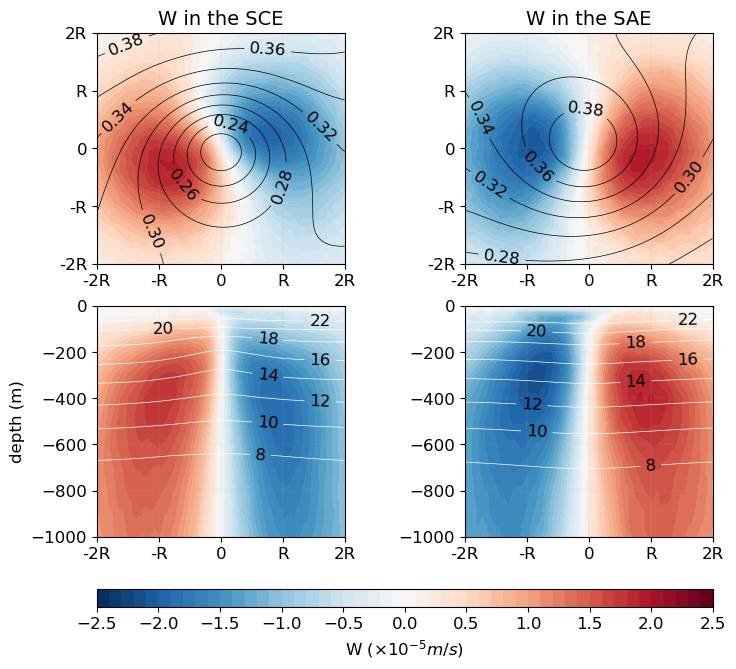

In [37]:
lev1=np.linspace(-1.,1.,101)
lev2=np.linspace(-2.5,2.5,51)

fig = plt.figure(figsize=(8, 7))
# 子图大小位置
pos1=[0.14,0.59,0.31,0.33] #左,下,长度,高度
pos2=[0.60,0.59,0.31,0.33]
pos3=[0.14,0.20,0.31,0.33]
pos4=[0.60,0.20,0.31,0.33]
cbar_pos = [0.14, 0.10, 0.77, 0.025]  # 统一的 colorbar 位置

# 子图 1
ax1 = plt.axes(pos1)
etan = SCE_e.plot.contour(levels=lev1, colors='k', linewidths=0.5)
plt.clabel(etan, inline=10, fontsize=12)
(SCE_w[12,:,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False)
plt.grid(linewidth='0.1')
plt.title('W in the SCE',fontsize=14,fontweight='500') # in 50m
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)

# 子图 2
ax2 = plt.axes(pos2)
etan = SAE_e.plot.contour(levels=lev1, colors='k', linewidths=0.5)
plt.clabel(etan, inline=10, fontsize=12)
(SAE_w[12,:,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False)
plt.grid(linewidth='0.1')
plt.title('W in the SAE',fontsize=14,fontweight='500') # in 50m
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)

# 子图 3
ax3 = plt.axes(pos3)
theta = SCE_t[:,51,:].plot.contour(levels=10, colors='w', linewidths=0.5)#linestyles='dashed', 
plt.clabel(theta, inline=10, fontsize=12, colors='k')
(SCE_w[:,51,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False) #cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)')
plt.grid(linewidth='0.1')
plt.title('') # in profile
plt.ylim([-1000,0])
plt.xlabel('')
plt.ylabel('depth (m)', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax3.set_xticks(ticks)
ax3.set_xticklabels(tlabels)


# 子图 4
ax4 = plt.axes(pos4)
theta = SAE_t[:,51,:].plot.contour(levels=10, colors='w', linewidths=0.5)#linestyles='dashed', 
plt.clabel(theta, inline=10, fontsize=12, colors='k')
sww = (SAE_w[:,51,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False) #cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)')
plt.grid(linewidth='0.1')
plt.title('') # in profile
plt.ylim([-1000,0])
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax4.set_xticks(ticks)
ax4.set_xticklabels(tlabels)

# 添加colorbar
cbar_ax = plt.axes(cbar_pos)
cbar = plt.colorbar(sww, cax=cbar_ax, orientation='horizontal', ticks=[np.linspace(-2.5, 2.5, 11)])#, label=r'W ($ \times 10^{-5} m/s$)')
cbar.set_label(r'W ($ \times 10^{-5} m/s$)', fontsize=12)  # 纵向或横向均可
cbar.ax.tick_params(labelsize=12)

# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig4.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=300)
# plt.close()

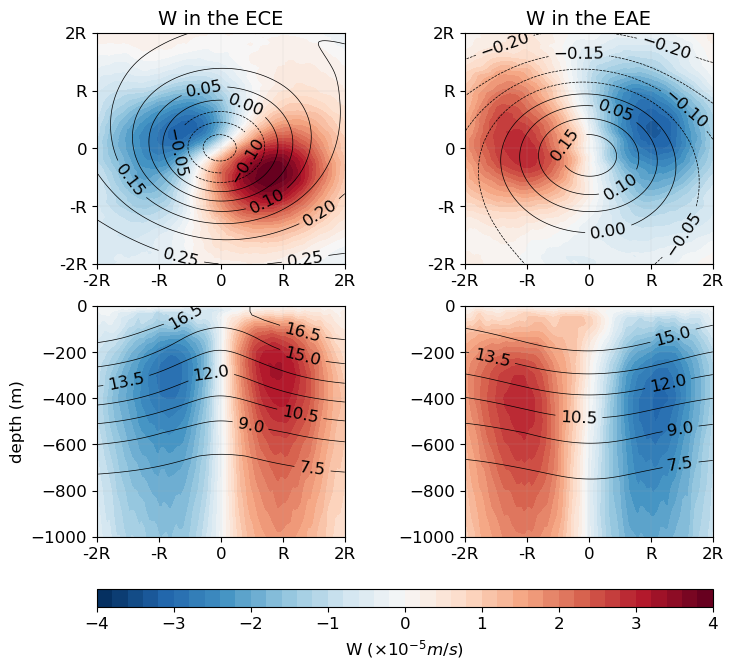

In [34]:
lev1=np.linspace(-1.5,1.5,61)
lev2=np.linspace(-4,4,41)

fig = plt.figure(figsize=(8, 7))
# 子图大小位置
pos1=[0.14,0.59,0.31,0.33] #左,下,长度,高度
pos2=[0.60,0.59,0.31,0.33]
pos3=[0.14,0.20,0.31,0.33]
pos4=[0.60,0.20,0.31,0.33]
cbar_pos = [0.14, 0.10, 0.77, 0.025]  # 统一的 colorbar 位置

# 子图 1
ax1 = plt.axes(pos1)
etan = ECE_e.plot.contour(levels=lev1, colors='k', linewidths=0.5)
plt.clabel(etan, inline=10, fontsize=12)
(ECE_w[12,:,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False)
plt.grid(linewidth='0.1')
plt.title('W in the ECE',fontsize=14,fontweight='500') # in 50m
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ticks  = [-2,-1,0,1,2]
tlabels= ['-2R','-R','0','R','2R']
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(tlabels)
ax1.set_yticklabels(tlabels)

# 子图 2
ax2 = plt.axes(pos2)
etan = EAE_e.plot.contour(levels=lev1, colors='k', linewidths=0.5)
plt.clabel(etan, inline=10, fontsize=12)
(EAE_w[12,:,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False)
plt.grid(linewidth='0.1')
plt.title('W in the EAE',fontsize=14,fontweight='500') # in 50m
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tlabels)
ax2.set_yticklabels(tlabels)

# 子图 3
ax3 = plt.axes(pos3)
theta = ECE_t[:,51,:].plot.contour(levels=10, colors='k', linewidths=0.5)#linestyles='dashed', 
plt.clabel(theta, inline=10, fontsize=12, colors='k')
(ECE_w[:,51,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False,)# cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
plt.grid(linewidth='0.1')
plt.title('') # in profile
plt.ylim([-1000,0])
plt.xlabel('')
plt.ylabel('depth (m)', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax3.set_xticks(ticks)
ax3.set_xticklabels(tlabels)

# 子图 4
ax4 = plt.axes(pos4)
theta = EAE_t[:,51,:].plot.contour(levels=10, colors='k', linewidths=0.5)#linestyles='dashed', 
plt.clabel(theta, inline=10, fontsize=12, colors='k')
eww=(EAE_w[:,51,:]*100000).plot.contourf(cmap='RdBu_r', levels=lev2, add_colorbar=False,)# cbar_kwargs=dict(label=r'W ($ \times 10^{-5} m/s$)'))
plt.grid(linewidth='0.1')
plt.title('') # in profile
plt.ylim([-1000,0])
plt.xlabel('')
plt.ylabel('', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
ax4.set_xticks(ticks)
ax4.set_xticklabels(tlabels)

# 添加colorbar
cbar_ax = plt.axes(cbar_pos)
cbar = plt.colorbar(eww, cax=cbar_ax, orientation='horizontal', ticks=[np.linspace(-4, 4, 9)])#, label=r'W ($ \times 10^{-5} m/s$)')
cbar.set_label(r'W ($ \times 10^{-5} m/s$)', fontsize=12)  # 纵向或横向均可
cbar.ax.tick_params(labelsize=12)

# 保存图片
savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/'
saveName = 'fig5.png'

fp0 = os.path.exists(savePath)
if not fp0:
    os.makedirs(savePath)
plt.savefig(savePath + saveName, dpi=150)
# plt.close()